In [1]:
# Copyright 2023 Andrew Lehr
# The MIT LICENSE

# # Dynamic control of neural manifolds
#### Lehr, Kumar, & Tetzlaff

####
### Code to produce Figure 5

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os.path as path
import os

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from submanifolds.utils import get_root
from submanifolds.ringnet.network import RingNetworkVariableSpeed
from submanifolds.ringnet import Parameters
from submanifolds.ringnet import Plot
from submanifolds.utils import get_root

### Color palettes

In [3]:
colors = ['#586ba4', '#f68e5f', '#f5dd90',  
          '#067d7a', '#77c1b3',  '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

In [10]:
root = get_root()
save_figs_flag = 0

# Figure storage
fig_top_dir = root + 'figures/'
fig_dir = fig_top_dir + 'figure_5/'

# Data storage
data_top_dir = root + 'data/'
data_dir = data_top_dir + 'time_dependent_speed_control/'

if not os.path.isdir(fig_top_dir):
    os.mkdir(fig_top_dir)
    print('Created ' + fig_top_dir)
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)
    print('Created ' + fig_dir)
else:
    print('fig dir exists')

if not os.path.isdir(data_top_dir):
    os.mkdir(data_top_dir)
    print('Created ' + data_top_dir)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    print('Created ' + data_dir)
else:
    print('data dir exists')

fig dir exists
data dir exists


In [5]:
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [6]:
sigma = 0.04
shift = 0.04
_w_E = 5 #4
N = 1000
T = 1001 #2501#1450
tau = 100 
p = 0

params_to_update = {'keys':     ['N','sigma_percent', 'shift_percent', 'T', '_w_E', 'p_inh', 'stim', 'type'], 
                    'setting':  [N, sigma, shift, T, _w_E, p, 'transient', 'projection']}

/home/andrew/Documents/projects/submanifolds/submission_dynamic_control/code/submanifolds/ringnet/parameters.py:66: UserWarning: Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.
  warnings.warn('Recurrent weights were rescaled due to selective inhibition and transient excitatory burst input.')


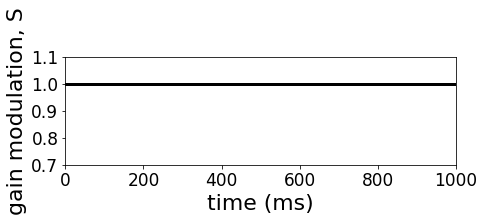

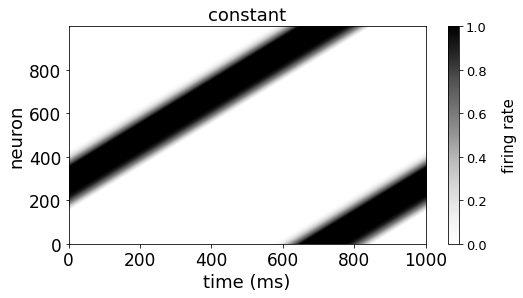

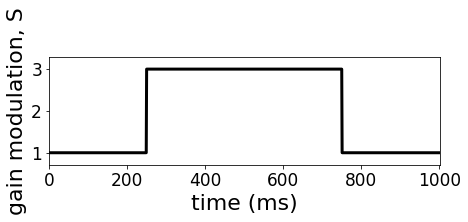

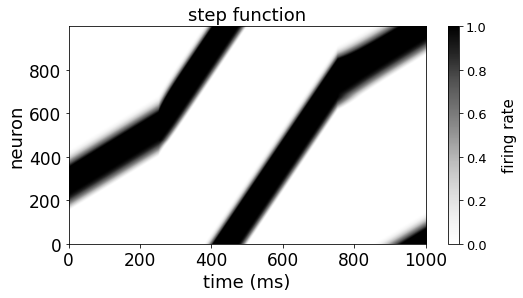

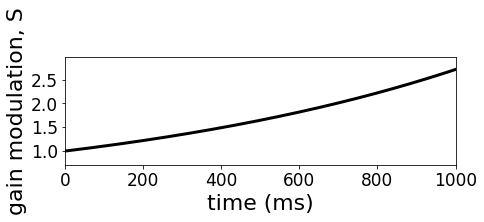

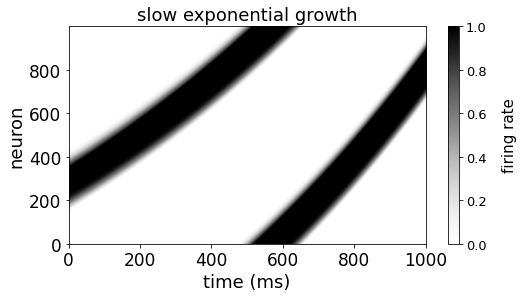

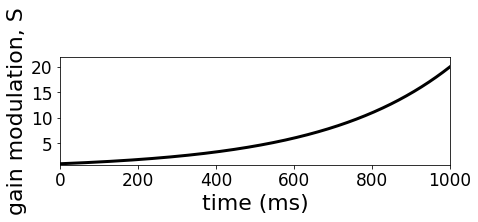

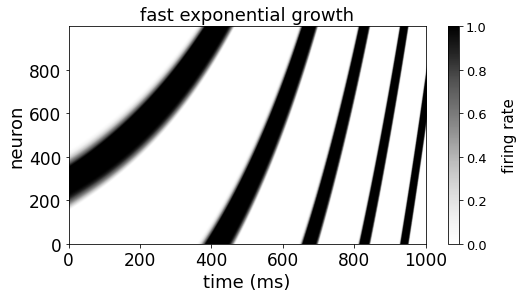

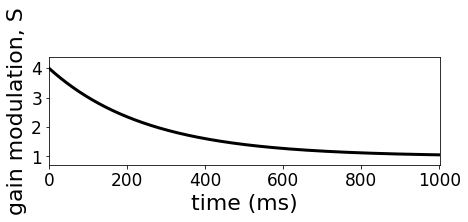

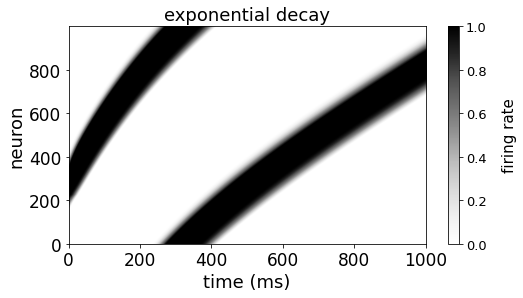

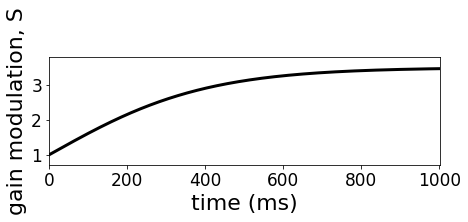

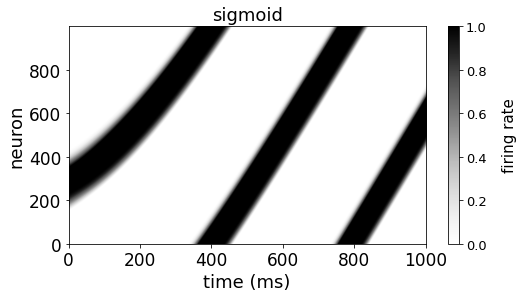

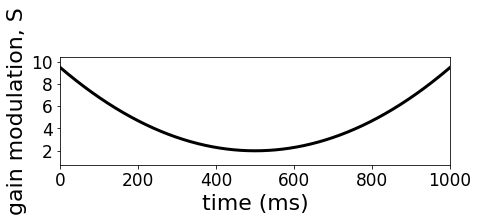

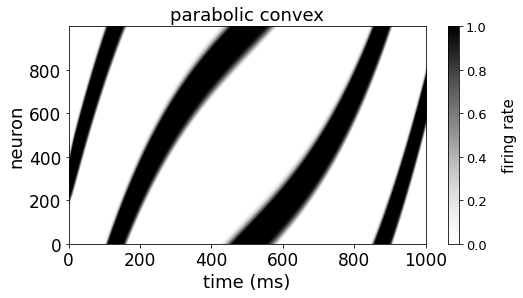

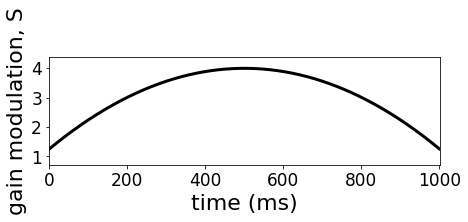

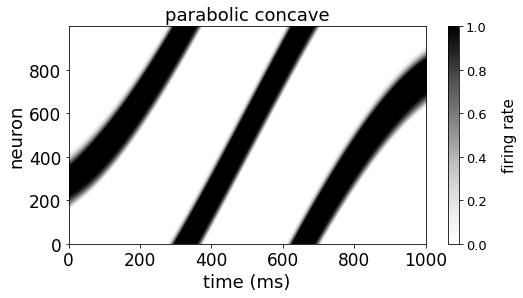

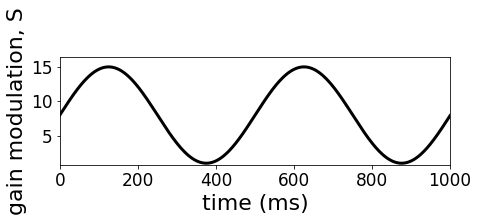

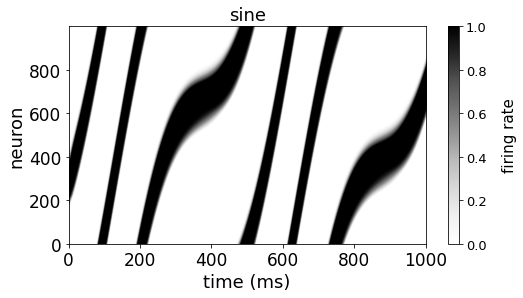

In [8]:
params = Parameters(params_to_update)

# speed control
time_steps = np.arange(T)

speed_input_dict = {'constant': np.ones(T),
                    'step function': np.concatenate([np.ones(int(T/4)), 3*np.ones(int(T/2)+1), np.ones(int(T/4))]),
                    'slow exponential growth': np.exp(time_steps/T),
                    'fast exponential growth': np.exp(3*time_steps/T),
                    'exponential decay': 1 + 3*np.exp(-time_steps/(.25*T)),
                    'sigmoid': 5 / (1 + np.exp(-.005*time_steps)) - 1.5,
                    'parabolic convex': 2 + 30*(time_steps/T - .5)*(time_steps/T - .5), # 2,30
                    'parabolic concave': 4 - 11*(time_steps/T - .5)*(time_steps/T - .5),
                    'sine': 8 + 7*np.sin(2*np.pi*time_steps/(0.5*T))} # 8, 7


n_input_strengths = len(speed_input_dict)
active_neurons = np.zeros((n_input_strengths, T))
raster = np.zeros((N,T,n_input_strengths))

# activation function maxima 
r_max_vals = [0] #[-0.5,-0.3,0,0.5,1]
n_r_max_vals = len(r_max_vals)
r_max = np.ones((T,N))


# generate initial condition
S = speed_input_dict[list(speed_input_dict.keys())[0]]
net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
initial_t = 250
center = 0
x = net.params.x
width = int(net.params.sigma)
max_active = net.params.P * r_max[0]
initial_r = max_active * np.exp(-0.5 * (x - center)**2 / (width)**2)
params.initial_r = initial_r
net.run()
initial_r = net.R[:,initial_t]
params.initial_r = initial_r


for i, (key, value) in enumerate(speed_input_dict.items()):
    
    fname = 'speed_time_dependent_function_' + key
    plt.figure(figsize=(7,2))
    plt.plot(value, color='black', linewidth=3)

    plt.xlabel('time (ms)', fontsize=22)
    plt.ylabel('gain modulation, S', fontsize=22)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlim(0,T)
    plt.ylim(0.7,1.1*np.max(value))
    if save_figs_flag:
        plt.savefig(fig_dir+fname+'.pdf', bbox_inches="tight")
        plt.savefig(fig_dir+fname+'.png', dpi=200, bbox_inches="tight")
    plt.show()
    
    fname = 'speed_time_dependent_raster_' + key + '.pdf'
    S = value
    net = RingNetworkVariableSpeed(params, S=S, tau=tau, r_max=r_max) 
    net.run()
    plotter = Plot()
    if save_figs_flag == 1:
        plotter.activity_raster(net.R, title=key, figsize=(8,4), xlabel='time (ms)', labelsize=22, storage_loc=fig_dir+fname)
    else:
        plotter.activity_raster(net.R, title=key, xlabel='time (ms)', figsize=(8,4))
    active_neurons[i, :] = np.sum(net.R > 0, axis=0)
    raster[:,:,i] = net.R